In [ ]:
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

^C


In [ ]:
#Import 
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as img
import zipfile
import re
from os import listdir
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torch
from PIL import Image
import pandas as pd
from torchvision import transforms
from sklearn.model_selection import train_test_split
import glob
import random

In [ ]:
with zipfile.ZipFile("dogs-vs-cats-redux-kernels-edition.zip","r") as zip_ref:
    zip_ref.extractall("./datakaggle")

In [ ]:
with zipfile.ZipFile("datakaggle/test.zip","r") as zip_ref:
    zip_ref.extractall("./datakaggle")
with zipfile.ZipFile("datakaggle/train.zip","r") as zip_ref:
    zip_ref.extractall("./datakaggle")

In [ ]:
for i in range(10):
  im = img.imread('datakaggle/train/cat.{}.jpg'.format(i))
  print('image shape', im.shape, 'maximum color level', im.max())

image shape (374, 500, 3) maximum color level 255
image shape (280, 300, 3) maximum color level 248
image shape (396, 312, 3) maximum color level 255
image shape (414, 500, 3) maximum color level 255
image shape (375, 499, 3) maximum color level 255
image shape (144, 175, 3) maximum color level 255
image shape (303, 400, 3) maximum color level 255
image shape (499, 495, 3) maximum color level 255
image shape (345, 461, 3) maximum color level 255
image shape (425, 320, 3) maximum color level 247


mauvaises images chat : 3216, 4688, 51418, 6215, 7377, 7564, 8456, 10712, 11565, 12272 (dessin : 2939, 3216, 8470, 11565)
mauvaises images chient : 1895, 4218, 5604, 6413, 8736, 8898, 9188, 9517, 10161, 10190, 10237, 10401, 10797, 11186

In [ ]:
bad_dogs_ids= [1895, 5604, 6413, 8736, 8898, 9188, 9517, 10161, 10190, 10237, 10401, 10797, 11186]
bad_cats_ids= [3216, 4688, 5418, 6215, 7377, 7564, 8456, 10712, 11565, 12272]

In [ ]:
def load_img(ids,animal):
    images=[]
    for id in ids:
        file_name="datakaggle/train/{animal}.{id}.jpg".format(animal=animal,id=id)
        i=img.imread(file_name)
        images.append(i)
    return images
    
def plot_images(images, ids):
    ncols, nrows = 4, 4
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img, id) in enumerate(zip(images,ids)):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.title(str(id))
        plt.axis('off')

In [ ]:
bad_dogs=load_img(bad_dogs_ids,"dog") 
bad_cats=load_img(bad_cats_ids,"cat") 

datakaggle/train/dog.1895.jpg


AttributeError: imread

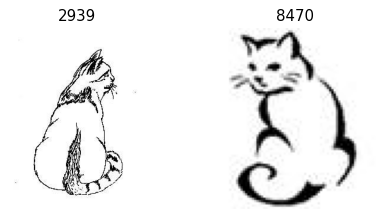

In [ ]:
#plot_images(bad_dogs,bad_dogs_ids)
#plot_images(bad_cats,bad_cats_ids)

plot_images(load_img([2939, 8470],"cat"),[2939, 8470])

In [ ]:
def cleanup(ids,dirname,animal):
    train="datakaggle/train/"
    trash="datakaggle/{}/".format(dirname)
    if os.path.isdir(trash):
        shutil.rmtree(trash)
    os.makedirs(trash, exist_ok=True)
    fic=([f for f in listdir(train) if animal in f])
    for f in fic:
        id=re.findall("\d+",f)[0]
        for i in ids:
            if i==int(id):
                print("moving to {}: {}".format(trash, id))
                shutil.move("{}{}".format(train,f),trash)

In [ ]:
cleanup(bad_cats_ids,"trash_cat","cat") #image move in trash_cat
cleanup(bad_dogs_ids,"trash_dog","dog") #image move in trash_dog

In [ ]:
DIR_TRAIN = "datakaggle/train/"
DIR_TEST = "datakaggle/test/"

In [ ]:
df=glob.glob(os.path.join(DIR_TRAIN,"*.jpg"))
test_list=glob.glob(os.path.join(DIR_TEST,"*.jpg"))
train_list, val_list = train_test_split(df, test_size=0.2)
print(len(train_list),len(val_list),len(test_list))



19981 4996 12500


In [ ]:
transformation =  transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    ])

In [ ]:

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0].split("\\")[1]
        if label == "dog":
            label=1
        elif label == "cat":
            label=0
            
        return img_transformed,label

In [ ]:

batch_size=100

train_data = dataset(train_list, transform=transformation)
val_data = dataset(val_list, transform=transformation)
test_data = dataset(test_list, transform=transformation)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

train_data[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0),-1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [ ]:
#entrainement du modèle sur 50 époques

epochs = 50
fn_perte = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = fn_perte(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = fn_perte(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.5799950361251831, train loss : 0.6766775846481323
Epoch : 1, val_accuracy : 0.632558286190033, val_loss : 0.6457805633544922
Epoch : 2, train accuracy : 0.6400101184844971, train loss : 0.6394423842430115
Epoch : 2, val_accuracy : 0.6683585047721863, val_loss : 0.6187071800231934
Epoch : 3, train accuracy : 0.6726716160774231, train loss : 0.6144369840621948
Epoch : 3, val_accuracy : 0.6673917174339294, val_loss : 0.6123293042182922
Epoch : 4, train accuracy : 0.6794248819351196, train loss : 0.5996952056884766
Epoch : 4, val_accuracy : 0.6777249574661255, val_loss : 0.6108037829399109
Epoch : 5, train accuracy : 0.6980803608894348, train loss : 0.5808483958244324
Epoch : 5, val_accuracy : 0.7087500691413879, val_loss : 0.5630588531494141
Epoch : 6, train accuracy : 0.7094570994377136, train loss : 0.5661513209342957
Epoch : 6, val_accuracy : 0.695666491985321, val_loss : 0.5892516374588013
Epoch : 7, train accuracy : 0.7164685726165771, train loss : 0.549

In [ ]:
torch.save(model,"model")

In [ ]:
model_trained=torch.load("model")

In [ ]:
#test d'ajout d'époques sur modèle entrainé avec 50 époques (non concluant l'accuracy stagne)

epochs = 10
fn_perte = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_trained.parameters(), lr = 0.01)

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model_trained(data)
        loss = fn_perte(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model_trained(data)
            val_loss = fn_perte(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.8169592022895813, train loss : 0.3916657567024231
Epoch : 1, val_accuracy : 0.8374998569488525, val_loss : 0.3608491122722626
Epoch : 2, train accuracy : 0.8214178681373596, train loss : 0.3824564218521118
Epoch : 2, val_accuracy : 0.8334251642227173, val_loss : 0.3617945611476898
Epoch : 3, train accuracy : 0.8214944005012512, train loss : 0.3823108375072479
Epoch : 3, val_accuracy : 0.8328999280929565, val_loss : 0.36005499958992004
Epoch : 4, train accuracy : 0.8256683349609375, train loss : 0.3747209310531616
Epoch : 4, val_accuracy : 0.7990667223930359, val_loss : 0.4211665987968445
Epoch : 5, train accuracy : 0.8230008482933044, train loss : 0.3764663636684418
Epoch : 5, val_accuracy : 0.8128748536109924, val_loss : 0.4032205641269684
Epoch : 6, train accuracy : 0.8237471580505371, train loss : 0.37672707438468933
Epoch : 6, val_accuracy : 0.802858293056488, val_loss : 0.42717939615249634
Epoch : 7, train accuracy : 0.81886225938797, train loss : 0.3

In [ ]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model_trained(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))

In [ ]:
dog_probs.sort(key = lambda x : int(x[0]))

In [ ]:
id = list(map(lambda x: x[0],dog_probs))
proba = list(map(lambda x: x[1],dog_probs))
submission = pd.DataFrame({'id':id,'label':proba})
submission

,id,label
0,1,0.881070
1,2,0.967919
2,3,0.801822
3,4,0.967919
4,5,0.015801
...,...,...
12495,12496,0.000497
12496,12497,0.245710
12497,12498,0.813217
12498,12499,0.967919


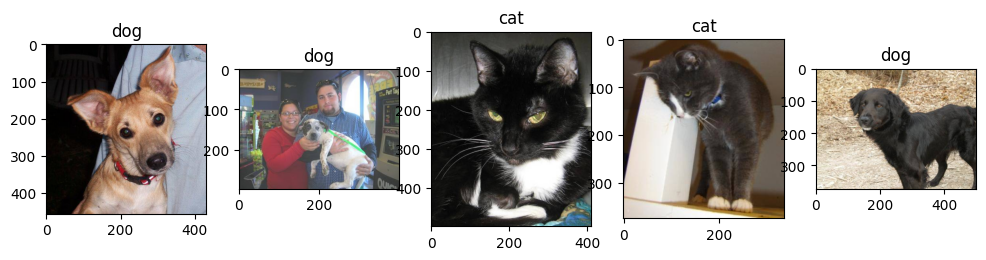

In [ ]:
id_list = []
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(1, 5, figsize=(12, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(DIR_TEST, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

In [ ]:
submission.to_csv("sample_submission.csv",index=False)